In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch.optim as optim
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define SingleRR model

In [3]:
class SingleRR(nn.Module):
    def __init__(self, embedding_dim, dropout_rate=0.1):
        """
        SingleRR model for a single embedding regression (ridge regression).

        Args:
            embedding_dim (int): Dimension of the input embedding.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(SingleRR, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        # Linear layer outputs a single value per sample.
        self.linear = nn.Linear(embedding_dim, 1)

    def forward(self, emb):
        """
        Args:
            emb (torch.Tensor): Tensor of shape (N, embedding_dim)

        Returns:
            logits (torch.Tensor): Tensor of shape (N,), representing the predicted continuous score.
        """
        x = self.dropout(emb)
        logits = self.linear(x)  # shape: (N, 1)
        return logits.squeeze(1)  # shape: (N,)

# Define functions to load data and train model

In [4]:
def load_data_single(emb, labels, batch, batch_size, device):
    """
    Loads a batch of data from the single-embedding dataset.

    Args:
        emb (np.ndarray): Array of shape (N, embedding_dim).
        labels (np.ndarray): Array of shape (N,) with continuous targets.
        batch (int): current batch index (starting from 0).
        batch_size (int)
        device (torch.device)

    Returns:
        data_batch (torch.Tensor): Tensor of shape (batch_size, embedding_dim)
        labels_batch (torch.Tensor): Tensor of shape (batch_size,)
    """
    if (batch+1)*batch_size > len(labels):
        idx = np.arange(batch*batch_size, len(labels))
    else:
        idx = np.arange(batch*batch_size, (batch+1)*batch_size)
    data_batch = emb[idx]
    labels_batch = labels[idx]
    data_batch = torch.from_numpy(data_batch).to(torch.float32).to(device)
    labels_batch = torch.from_numpy(labels_batch).to(torch.float32).to(device)
    return data_batch, labels_batch


def train_epoch_single(model, optimizer, emb, labels, batch_size, device):
    model.train()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total_samples = 0
    num_batches = math.ceil(len(labels) / batch_size)
    for batch in range(num_batches):
        data_batch, labels_batch = load_data_single(emb, labels, batch, batch_size, device)
        preds = model(data_batch)
        loss = criterion(preds, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data_batch.size(0)
        total_samples += data_batch.size(0)
    avg_loss = running_loss / total_samples
    return avg_loss


def test_epoch_single(model, emb, labels, batch_size, device):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total_samples = 0
    all_preds = []
    all_targets = []
    num_batches = math.ceil(len(labels) / batch_size)
    with torch.no_grad():
        for batch in range(num_batches):
            data_batch, labels_batch = load_data_single(emb, labels, batch, batch_size, device)
            preds = model(data_batch)
            loss = criterion(preds, labels_batch)
            running_loss += loss.item() * data_batch.size(0)
            total_samples += data_batch.size(0)
            all_preds.append(preds)
            all_targets.append(labels_batch)
    avg_loss = running_loss / total_samples
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    # Compute Spearman correlation (convert to numpy arrays)
    spearman_corr, _ = spearmanr(all_preds.cpu().numpy(), all_targets.cpu().numpy())
    return avg_loss, spearman_corr, all_preds, all_targets

# Train the model and save results

Zero-skill test baseline: 100%|██████████| 49/49 [00:00<00:00, 3868.70it/s]


Zero skill training loss: 3.4822, Spearman: 0.0199
Zero skill test loss: 3.5065, Spearman: -0.0290
Epoch 1: Train Loss: 3.2826 | Test Loss: 2.9356 | Test Spearman: 0.4793
Epoch 2: Train Loss: 2.8768 | Test Loss: 2.6358 | Test Spearman: 0.5385
Epoch 3: Train Loss: 2.7060 | Test Loss: 2.5052 | Test Spearman: 0.5816
Epoch 4: Train Loss: 2.5622 | Test Loss: 2.3472 | Test Spearman: 0.6067
Epoch 5: Train Loss: 2.4806 | Test Loss: 2.2613 | Test Spearman: 0.6257
Epoch 6: Train Loss: 2.4310 | Test Loss: 2.2800 | Test Spearman: 0.6390
Epoch 7: Train Loss: 2.3298 | Test Loss: 2.1880 | Test Spearman: 0.6492
Epoch 8: Train Loss: 2.2907 | Test Loss: 2.1260 | Test Spearman: 0.6556
Epoch 9: Train Loss: 2.2408 | Test Loss: 2.0896 | Test Spearman: 0.6641
Epoch 10: Train Loss: 2.1804 | Test Loss: 2.0584 | Test Spearman: 0.6688
Epoch 11: Train Loss: 2.1130 | Test Loss: 2.0326 | Test Spearman: 0.6717
Epoch 12: Train Loss: 2.1248 | Test Loss: 2.0064 | Test Spearman: 0.6792
Epoch 13: Train Loss: 2.1107 | Tes

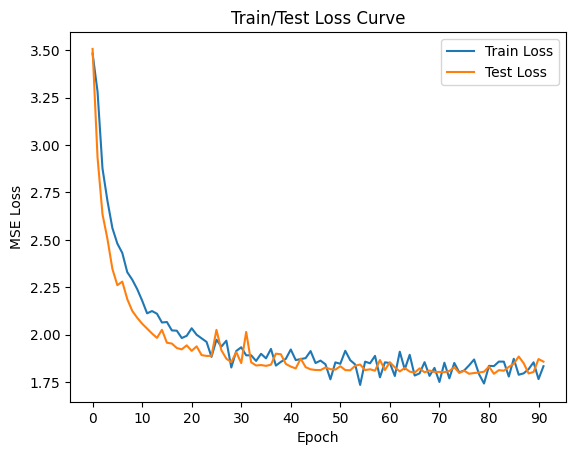

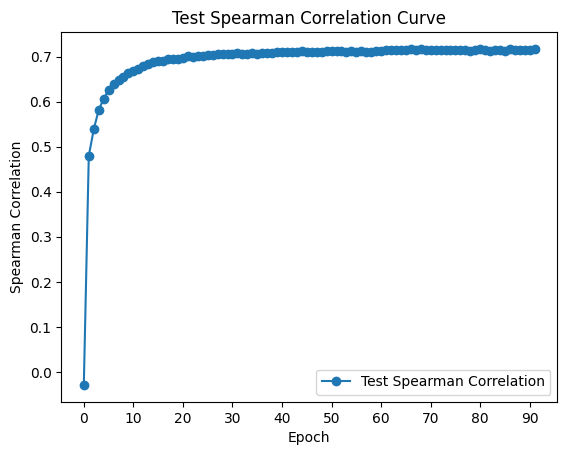

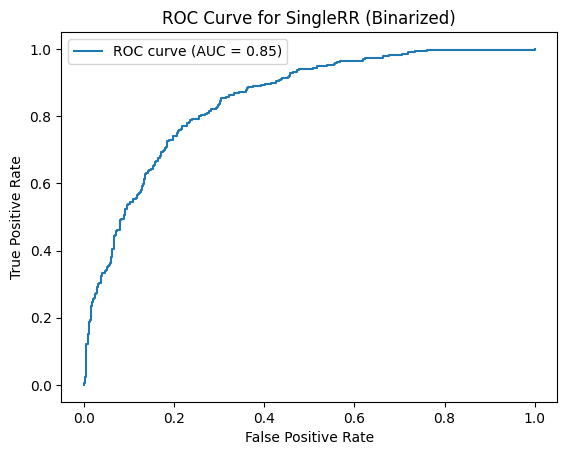

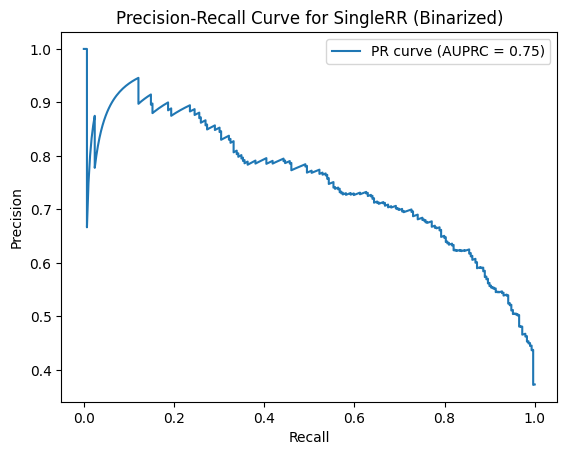

Final Test Accuracy (binarized): 0.7768
Final Test Precision (binarized): 0.7042
Final Test Recall (binarized): 0.6920


In [5]:
if __name__ == '__main__':

    # Hyperparameters
    n_epoch = 300
    batch_size = 16
    embedding_dim = 1882  # from your single embedding files
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Load dataset, AAIndex embeddings and PLL from the specified directory
    AAindex = np.load("/content/drive/MyDrive/Mid_1_data_train/AAindex_emb_r3.npy")
    PLL = np.load("/content/drive/MyDrive/Mid_1_data_train/PLL_r3.npy")
    train_df = pd.read_csv('/content/drive/MyDrive/Mid_1_data_train/data_single_train_r3.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Mid_1_data_train/data_single_test_r3.csv')
    seq2idx = pickle.load(open('/content/drive/MyDrive/Mid_1_data_train/seq_to_index_r3.pkl', 'rb'))

    train_idx = [seq2idx[seq.rstrip('*')] for seq in list(train_df['seq'])]
    test_idx = [seq2idx[seq.rstrip('*')] for seq in list(test_df['seq'])]

    train_emb = np.concatenate((AAindex[np.array(train_idx)], PLL[np.array(train_idx)]), axis=1)
    test_emb = np.concatenate((AAindex[np.array(test_idx)], PLL[np.array(test_idx)]), axis=1)
    train_labels = np.array(list(train_df['fitness']))
    test_labels = np.array(list(test_df['fitness']))


    # Instantiate model and optimizer.
    model = SingleRR(embedding_dim, dropout_rate=0.1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Compute zero-skill baseline (epoch 0): run the untrained model on training and test sets.
    model.eval()
    # Zero skill for training set
    num_batch_train = math.ceil(len(train_labels) / batch_size)
    zero_train_preds = []
    zero_train_targets = []
    for batch in tqdm(range(num_batch_train), desc="Zero-skill train baseline"):
        data_batch, labels_batch = load_data_single(train_emb, train_labels, batch, batch_size, device)
        preds = model(data_batch)
        zero_train_preds.append(preds)
        zero_train_targets.append(labels_batch)
    zero_train_preds = torch.cat(zero_train_preds, dim=0)
    zero_train_targets = torch.cat(zero_train_targets, dim=0)
    criterion_reg = nn.MSELoss()
    zero_train_loss = criterion_reg(zero_train_preds, zero_train_targets).item()
    # For correlation baseline:
    from scipy.stats import spearmanr
    zero_train_spearman, _ = spearmanr(zero_train_preds.cpu().detach().numpy(), zero_train_targets.cpu().detach().numpy())

    # Zero skill for test set
    num_batch_test = math.ceil(len(test_labels) / batch_size)
    zero_test_preds = []
    zero_test_targets = []
    for batch in tqdm(range(num_batch_test), desc="Zero-skill test baseline"):
        data_batch, labels_batch = load_data_single(test_emb, test_labels, batch, batch_size, device)
        preds = model(data_batch)
        zero_test_preds.append(preds)
        zero_test_targets.append(labels_batch)
    zero_test_preds = torch.cat(zero_test_preds, dim=0)
    zero_test_targets = torch.cat(zero_test_targets, dim=0)
    zero_test_loss = criterion_reg(zero_test_preds, zero_test_targets).item()
    zero_test_spearman, _ = spearmanr(zero_test_preds.cpu().detach().numpy(), zero_test_targets.cpu().detach().numpy())

    print("Zero skill training loss: {:.4f}, Spearman: {:.4f}".format(zero_train_loss, zero_train_spearman))
    print("Zero skill test loss: {:.4f}, Spearman: {:.4f}".format(zero_test_loss, zero_test_spearman))

    # Prepare lists that include epoch 0 as the baseline.
    train_losses = [zero_train_loss]
    test_losses = [zero_test_loss]
    test_spearman = [zero_test_spearman]

    # Training loop with early stopping on test loss
    patience = 10
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, n_epoch+1):
        train_loss = train_epoch_single(model, optimizer, train_emb, train_labels, batch_size, device)
        test_loss, spearman_corr, test_preds, test_targets = test_epoch_single(model, test_emb, test_labels, batch_size, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_spearman.append(spearman_corr)
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Spearman: {spearman_corr:.4f}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            # Save model with lowest test loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/Mid_1_RR_results/SingleRR_best_model.pt")
            best_test_preds = test_preds.clone()
            best_test_targets = test_targets.clone()
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


    epochs_x = range(len(train_losses))
    tick_positions = np.arange(0, len(train_losses), 10)
    plt.figure()
    plt.plot(epochs_x, train_losses, label="Train Loss")
    plt.plot(epochs_x, test_losses, label="Test Loss")
    plt.xticks(tick_positions)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Train/Test Loss Curve")
    plt.legend()
    plt.savefig("/content/drive/MyDrive/Mid_1_RR_results/single_loss_curve.png")

    plt.figure()
    plt.plot(epochs_x, test_spearman, label="Test Spearman Correlation", marker="o")
    plt.xticks(tick_positions)
    plt.xlabel("Epoch")
    plt.ylabel("Spearman Correlation")
    plt.title("Test Spearman Correlation Curve")
    plt.legend()
    plt.savefig("/content/drive/MyDrive/Mid_1_RR_results/single_spearman_curve.png")
    plt.show()

    # Save final test predictions and targets from best test loss epoch.
    final_results = {
        "preds": best_test_preds.cpu().numpy(),
        "targets": best_test_targets.cpu().numpy()
    }
    with open("/content/drive/MyDrive/Mid_1_RR_results/single_final_predictions.pkl", "wb") as f:
        pickle.dump(final_results, f)

    # --- Compute and plot ROC and PR curves ---
    # For regression we need to binarize the output.
    # Here, we assume a threshold of 0 (i.e. predict positive if value > 0, negative otherwise).
    # Create binary ground truth and predictions.
    best_test_preds_np = best_test_preds.cpu().numpy()
    best_test_targets_np = best_test_targets.cpu().numpy()
    binary_targets = (best_test_targets_np > 0).astype(int)
    binary_preds = (best_test_preds_np > 0).astype(int)
    # For computing ROC/AUC, we can use the continuous predictions as scores.
    auc_score = roc_auc_score(binary_targets, best_test_preds_np)
    prauc_score = average_precision_score(binary_targets, best_test_preds_np)

    fpr, tpr, _ = roc_curve(binary_targets, best_test_preds_np)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for SingleRR (Binarized)")
    plt.legend()
    plt.savefig("/content/drive/MyDrive/Mid_1_RR_results/single_roc_curve.png")

    precision, recall, _ = precision_recall_curve(binary_targets, best_test_preds_np)
    plt.figure()
    plt.plot(recall, precision, label=f"PR curve (AUPRC = {prauc_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for SingleRR (Binarized)")
    plt.legend()
    plt.savefig("/content/drive/MyDrive/Mid_1_RR_results/single_pr_curve.png")
    plt.show()

    # Binarize the best test predictions and targets (threshold = 0)
    binary_targets = (best_test_targets.cpu().detach().numpy() > 0).astype(int)
    binary_preds = (best_test_preds.cpu().detach().numpy() > 0).astype(int)

    # Calculate overall accuracy and precision
    final_test_accuracy  = accuracy_score(binary_targets, binary_preds)
    final_test_precision = precision_score(binary_targets, binary_preds, zero_division=0)
    final_test_recall    = recall_score(binary_targets, binary_preds, zero_division=0)

    print("Final Test Accuracy (binarized): {:.4f}".format(final_test_accuracy))
    print("Final Test Precision (binarized): {:.4f}".format(final_test_precision))
    print("Final Test Recall (binarized): {:.4f}".format(final_test_recall))
